## 7.1 数据处理

先载入一些必备的包：

In [1]:
import zipfile  # 处理压缩文件
import os

import pandas as pd  # 处理 csv 文件
import numpy as np
from matplotlib import pyplot as plt

# ----- 自定义模块
from utils.zipimage import AnnZ, ImageZ, Loader, Dataset
%matplotlib inline

查看 https://www.kaggle.com/c/dogs-vs-cats/data 下数据的基本信息。从该网址可以知道：训练数据 `tain.zip` 包括 $50\,000$ 个样本，其中猫和狗各半。而其任务是预测 `test1.zip` 的标签（$1 = dog, 0 = cat$）。为了方便将数据下载到本地，然后做如下操作：

为了以后方便处理其他的 Kaggle 提供的数据，将 `unzip` 函数封装到了 kaggle 包下的 helper 模块中。`unzip` 实现的功能是将 `root` 下的 `'all.zip'` 文件解压并返回解压后数据所在的目录，同时也将 `'all.zip'` 删除（之后用不到了）。

先看看 `dataDir` 目录下面都是什么文件？

In [2]:
dataDir = 'data/dog_cat'
os.listdir(dataDir)

['sampleSubmission.csv', 'test1.zip', 'train.zip']

文件 `'sampleSubmission.csv'` 是 kaggle 比赛提交预测结果的样式：

In [3]:
submit = pd.read_csv(os.path.join(dataDir, 'sampleSubmission.csv'))
submit.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


其中 `id` 表示 `test.zip` 中图片的文件名称，比如 `id = 1` 代表图片文件名为 `1.jpg`。`label` 表示图片的标签（1=dog,0=cat）。训练集和测试集都是 `.zip` 压缩文件，下面直接利用类 ImageZ 来读取数据：

In [4]:
testset = ImageZ(dataDir, 'test1') # 测试数据
trainZ = ImageZ(dataDir, 'train') # 训练数据

你也许会疑惑，训练数据的标签呢？其实，在 https://www.kaggle.com/c/dogs-vs-cats/data 中你查看 `train.zip` 便可以发现其类别信息隐藏在文件名中，为此，可以直接查看 trainZ 的 `names` 属性：

In [5]:
trainZ.names[:5]  # 查看其中的 5 个文件名

['train/cat.0.jpg',
 'train/cat.1.jpg',
 'train/cat.10.jpg',
 'train/cat.100.jpg',
 'train/cat.1000.jpg']

因而，对于训练数据可以通过文件名来获知其所属于的类别。为了与 `1=dog,0=cat` 对应，下面定义：

In [6]:
class_names = ('cat', 'dog')
class_names[1], class_names[0]

('dog', 'cat')

In [7]:
name_class_dict = {}   # 通过文件名获取图片的类别
class_dict = {class_name:i for i, class_name in enumerate(class_names)}
for name in trainZ.names:
    class_name = name.split('.')[0].split('/')[-1]
    name_class_dict[name] = class_dict[class_name]

为了后期处理方便，下面将其封装进 DataSet 类：

In [8]:
class DataSet(ImageZ):
    def __init__(self, dataDir, dataType):
        super().__init__(dataDir, dataType)
        self.class_names = ('cat', 'dog')  # 数据集的类名称
        self._get_name_class_dict()

    def _get_name_class_dict(self):
        self.name_class_dict = {}  # 通过文件名获取图片的类别
        class_dict = {
            class_name: i
            for i, class_name in enumerate(self.class_names)
        }
        for name in self.names:
            class_name = name.split('.')[0].split('/')[-1]
            self.name_class_dict[name] = class_dict[class_name]
            
    def __iter__(self):
        for name in self.names:
            # 返回 (data, label) 数据形式
            yield self.buffer2array(name), self.name_class_dict[name]

下面看看如何使用 DataSet 类：

大小： (374, 500, 3) 标签： 0


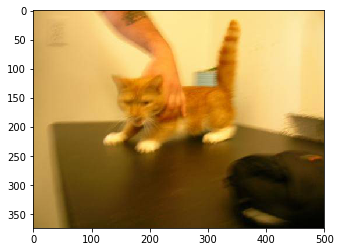

In [9]:
dataset = DataSet(dataDir, 'train')

for img, label in dataset:
    print("大小：",img.shape, '标签：', label)  # 查看一张图片
    plt.imshow(img)
    plt.show()
    break

为了查看模型的泛化性，需要将 dataset 划分为 trainset 与 valset，为此需要将 dataset 的 names 属性进行划分。由于 dataset 的特殊性，下面对 trainZ 进行处理比较好：

In [10]:
cat_rec = []
dog_rec = []
for name in trainZ.names:
    if name.startswith('train/cat'):
        cat_rec.append((name, 0))
    elif name.startswith('train/dog'):
        dog_rec.append((name, 1))

为了避免模型依赖于数据集的顺序，下面将会打乱原数据集的顺序：

In [33]:
import random
random.shuffle(cat_rec)  # 打乱 cat_names
random.shuffle(dog_rec)  # 打乱 dog_names

train_rec = cat_rec[:10000] + dog_rec[:10000]  # 各取其中的 10000 个样本作为训练
val_rec = cat_rec[10000:] + dog_rec[10000:]  # 剩余的作为测试
random.shuffle(train_rec)   # 打乱类别的分布，提高模型的泛化能力
random.shuffle(val_rec)
len(train_rec), len(val_rec)

(20000, 5000)

In [34]:
train_rec

[('train/cat.11244.jpg', 0),
 ('train/cat.5023.jpg', 0),
 ('train/dog.6682.jpg', 1),
 ('train/cat.6234.jpg', 0),
 ('train/dog.9677.jpg', 1),
 ('train/cat.11101.jpg', 0),
 ('train/dog.4782.jpg', 1),
 ('train/dog.10129.jpg', 1),
 ('train/cat.5362.jpg', 0),
 ('train/cat.2548.jpg', 0),
 ('train/cat.7818.jpg', 0),
 ('train/dog.282.jpg', 1),
 ('train/cat.8822.jpg', 0),
 ('train/dog.897.jpg', 1),
 ('train/dog.6501.jpg', 1),
 ('train/cat.5788.jpg', 0),
 ('train/cat.9715.jpg', 0),
 ('train/dog.3405.jpg', 1),
 ('train/dog.2670.jpg', 1),
 ('train/dog.458.jpg', 1),
 ('train/cat.11703.jpg', 0),
 ('train/dog.11255.jpg', 1),
 ('train/cat.9999.jpg', 0),
 ('train/dog.6932.jpg', 1),
 ('train/cat.2083.jpg', 0),
 ('train/cat.3138.jpg', 0),
 ('train/cat.7871.jpg', 0),
 ('train/dog.140.jpg', 1),
 ('train/cat.1475.jpg', 0),
 ('train/dog.7844.jpg', 1),
 ('train/dog.4460.jpg', 1),
 ('train/dog.12004.jpg', 1),
 ('train/dog.11769.jpg', 1),
 ('train/cat.10482.jpg', 0),
 ('train/cat.1559.jpg', 0),
 ('train/cat.798

从上面的代码我们可以知道，训练数据和验证数据的样本个数分别为：20000 和 5000。下面为了可以让模型能够使用该数据集，需要定义一个**生成器**：

In [12]:
class Loader(ImageZ):
    def __init__(self, imgZ, rec, shuffle=False, target_size=None):
        if shuffle:
            random.shuffle(rec)  # 训练集需要打乱
        self.imgZ = imgZ
        self.rec = rec
        self.target_size = target_size
        
    def transform(self, name):
        import cv2
        img = self.imgZ.buffer2array(name)
        if self.target_size:
            return cv2.resize(img, self.target_size)
        else:
            return img

    def __getitem__(self, item):
        rec = self.rec[item]
        if isinstance(item, slice):
            return [(self.transform(name), label) for (name, label) in rec]
        else:
            return self.transform(rec[0]), rec[1]

    def __iter__(self):
        for name, label in self.rec:
            yield self.transform(name), label  # 返回 (data, label)

    def __len__(self):
        return len(self.rec)  # 返回数据样本数

这样，便可以得到随机划分后的 `trainset` 和 `valset`。

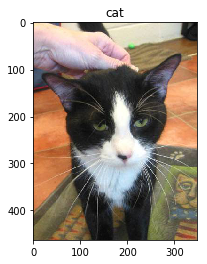

In [13]:
trainset = Loader(trainZ, train_rec, True)  # 训练集
valset = Loader(trainZ, val_rec)  # 验证集

for img, label in trainset:
    plt.imshow(img)    # 显示出图片
    plt.title(str(class_names[label]))  # 将类别作为标题
    plt.show()
    break

数据处理好之后，下面需要着手创建模型。先看看 Keras 是如何创建模型的？首先，看看图片的大小：

In [ ]:
name2size = {}   # 获得图片的 size
for name in trainZ.names:
    name2size[name] = trainZ.buffer2array(name).shape[:-1]
min({w for h, w in set(name2size.values())}), min({h for h, w in set(name2size.values())})

从上述代码可以看出：图片的最小高和宽分别为 32 和 42，基于此，不妨将所有的图片均 resize 为 `(150, 150)`。

## 7.2 Keras 实现模型的训练和预测

In [14]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


我们可以查看一下每层特征图的 Shape：

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 23, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 21, 128)       147584    
__________

为了模型可以训练，还需要对模型进行配置：

In [16]:
from keras import optimizers

model.compile(loss='binary_crossentropy',   # 针对 2 分类
              optimizer=optimizers.RMSprop(lr=1e-4),  # RMSprop 优化
              metrics=['acc'])  # 监控 精度

由于 model 的输入要求图片尺寸为 (150, 200)，所以：

In [29]:
class BatchLoader(Loader):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.target_size = target_size
        
    def __iter__(self):
        n = len(self.dataset) # 样本数
        idx_list = np.random.permutation(np.arange(n))
        for i in range(0, n, self.batch_size):
            idx = idx_list[i:min(i + batch_size, n)]
            batch1 =  (self.dataset[ix] for ix in idx) # 迭代器
            batch2 = (self.dataset[ix] for ix in idx)  # 迭代器
            yield np.stack([img for img, _ in batch1]), np.stack([label for _, label in batch2])
            
    def __len__(self):
        return len(self.dataset)

batch_size = 32
target_size = (150, 200)  # 统一图片的 size
trainset = Loader(trainZ, train_rec, True, target_size)  # 训练集 
valset = Loader(trainZ, val_rec, False, target_size)  # 验证集
val_loader = BatchLoader(valset, batch_size)
train_loader = BatchLoader(trainset, batch_size)

为了提高模型的泛化能力，还需要使用 ImageDataGenerator 类来做一些数据增强的操作：

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # 将所有图像乘以 1/255 来缩放像素值到 [0, 1]
    rotation_range=40,   # 表示图像随机旋转的角度范围
    width_shift_range=0.2,  # 水平方向上平移的范围（相对于总宽度或总高度的比例）
    height_shift_range=0.2,  # 垂直方向上平移的范围（相对于总宽度或总高度的比例）
    shear_range=0.2,      # 随机错切变换的角度
    zoom_range=0.2,       # 图像随机缩放的范围
    horizontal_flip=True,  # 图像随机缩放的范围, 如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的。
    fill_mode='nearest')  # 如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的。

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [31]:
history = model.fit()

In [ ]:
history = model.fit

In [19]:
for imgs, labels in val_loader:
    ss = train_datagen.flow(imgs, labels, batch_size=32)
    break

In [21]:
ss[0]

(array([[[[0.6627451 , 0.58431375, 0.45116597],
          [0.6627451 , 0.58431375, 0.45328838],
          [0.6612187 , 0.58278733, 0.45439318],
          ...,
          [0.406978  , 0.46580154, 0.4854094 ],
          [0.41483596, 0.4736595 , 0.49480298],
          [0.41960788, 0.4784314 , 0.5035038 ]],
 
         [[0.6627451 , 0.58431375, 0.44821402],
          [0.6627451 , 0.58431375, 0.45033643],
          [0.6627451 , 0.58431375, 0.45245886],
          ...,
          [0.41016817, 0.46899173, 0.48859957],
          [0.41802612, 0.47684968, 0.4995882 ],
          [0.41960788, 0.4784314 , 0.50509894]],
 
         [[0.65915155, 0.5807202 , 0.44166848],
          [0.6627451 , 0.58431375, 0.44738445],
          [0.6627451 , 0.58431375, 0.44950688],
          ...,
          [0.41335836, 0.4721819 , 0.49258652],
          [0.41960788, 0.4784314 , 0.50276506],
          [0.41879624, 0.47599658, 0.50425917]],
 
         ...,
 
         [[0.5756414 , 0.4994598 , 0.3801518 ],
          [0.57117